# **Homework 7 - Bert (Question Answering)**

If you have any questions, feel free to email us at ntu-ml-2021spring-ta@googlegroups.com



Slide:    [Link](https://docs.google.com/presentation/d/1aQoWogAQo_xVJvMQMrGaYiWzuyfO0QyLLAhiMwFyS2w)　Kaggle: [Link](https://www.kaggle.com/c/ml2021-spring-hw7)　Data: [Link](https://drive.google.com/uc?id=1znKmX08v9Fygp-dgwo7BKiLIf2qL1FH1)




In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Task description
- Chinese Extractive Question Answering
  - Input: Paragraph + Question
  - Output: Answer

- Objective: Learn how to fine tune a pretrained model on downstream task using transformers

- Todo
    - Fine tune a pretrained chinese BERT model
    - Change hyperparameters (e.g. doc_stride)
    - Apply linear learning rate decay
    - Try other pretrained models
    - Improve preprocessing
    - Improve postprocessing
- Training tips
    - Automatic mixed precision
    - Gradient accumulation
    - Ensemble

- Estimated training time (tesla t4 with automatic mixed precision enabled)
    - Simple: 8mins
    - Medium: 8mins
    - Strong: 25mins
    - Boss: 2hrs
  

For BERT這次作業，輸入表示為[CLS]問題[SEP]段落(一個window的量)[SEP] (在QA_Dataset中實作), 模型輸出預測答案的起始位置和結束位置。在訓練過程中，提供給模型問題、包含答案的段落，以及答案在段落中的真實起始和結束位置。model會學習調整自身的weight，使對於給定的問題和段落，真實答案的起始和結束位置的預測概率更高。

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive
%cd ./ML2021/homework7
!pwd

Mounted at /content/drive
/content/drive/MyDrive
/content/drive/MyDrive/ML2021/homework7
/content/drive/MyDrive/ML2021/homework7


## Download Dataset

In [ ]:
# Download link 1
#!gdown --id '1znKmX08v9Fygp-dgwo7BKiLIf2qL1FH1' --output hw7_data.zip

# Download Link 2 (if the above link fails)
# !gdown --id '1pOu3FdPdvzielUZyggeD7KDnVy9iW1uC' --output hw7_data.zip

#!unzip -o hw7_data.zip

# For this HW, K80 < P4 < T4 < P100 <= T4(fp16) < V100
#!nvidia-smi

## Install transformers

Documentation for the toolkit:　https://huggingface.co/transformers/

In [ ]:
!pip install transformers

## Import Packages

In [ ]:
import json
import numpy as np
import random
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import BertForQuestionAnswering, BertTokenizerFast
from transformers.optimization import get_linear_schedule_with_warmup
from torch.optim import AdamW

from tqdm.auto import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"

# Fix random seed for reproducibility
def same_seeds(seed):
	torch.manual_seed(seed)
	if torch.cuda.is_available():
		torch.cuda.manual_seed(seed)
		torch.cuda.manual_seed_all(seed)
	np.random.seed(seed)
	random.seed(seed)
	torch.backends.cudnn.benchmark = False
	torch.backends.cudnn.deterministic = True
same_seeds(0)

In [ ]:
# Change "fp16_training" to True to support automatic mixed precision training (fp16)
#fp16減少float表示bit,減少記憶體和更快的運算，精度較低
fp16_training = True

if fp16_training:
    !pip install --upgrade accelerate
    from accelerate import Accelerator
    accelerator = Accelerator(mixed_precision="fp16") #自動處理在模型的不同部分使用不同精度，有些fp16有些fp32
    device = accelerator.device

# Documentation for the toolkit:  https://huggingface.co/docs/accelerate/

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.1/362.1 kB 29.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 63.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 41.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 28.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 95.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

## Load Model and Tokenizer






In [ ]:
model = BertForQuestionAnswering.from_pretrained("bert-base-chinese").to(device)
tokenizer = BertTokenizerFast.from_pretrained("bert-base-chinese") #Tokenizer 作用是將輸入文本轉換為model可理解的tokenID，並處理預處理步驟，ex分詞、添加特殊token(CLS,SEP)等。

# You can safely ignore the warning message (it pops up because new prediction heads for QA are initialized randomly)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/624 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/412M [00:00<?, ?B/s]

Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-chinese and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/110k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/269k [00:00<?, ?B/s]

## Read Data

- Training set: 26935 QA pairs
- Dev set: 3523  QA pairs
- Test set: 3492  QA pairs

- {train/dev/test}_questions:
  - List of dicts with the following keys:
   - id (int)
   - paragraph_id (int)
   - question_text (string)
   - answer_text (string)
   - answer_start (int)
   - answer_end (int)
- {train/dev/test}_paragraphs:
  - List of strings
  - paragraph_ids in questions correspond to indexs in paragraphs
  - A paragraph may be used by several questions

In [ ]:
def read_data(file):
    with open(file, 'r', encoding="utf-8") as reader:
        data = json.load(reader)
    return data["questions"], data["paragraphs"]

train_questions, train_paragraphs = read_data("hw7_train.json")
dev_questions, dev_paragraphs = read_data("hw7_dev.json")
test_questions, test_paragraphs = read_data("hw7_test.json")

## Tokenize Data(分詞處理)


In [ ]:
# Tokenize questions and paragraphs separately
# 「add_special_tokens」 is set to False since special tokens will be added when tokenized questions and paragraphs are combined in datset __getitem__

train_questions_tokenized = tokenizer([train_question["question_text"] for train_question in train_questions], add_special_tokens=False)
dev_questions_tokenized = tokenizer([dev_question["question_text"] for dev_question in dev_questions], add_special_tokens=False)
test_questions_tokenized = tokenizer([test_question["question_text"] for test_question in test_questions], add_special_tokens=False)

train_paragraphs_tokenized = tokenizer(train_paragraphs, add_special_tokens=False)
dev_paragraphs_tokenized = tokenizer(dev_paragraphs, add_special_tokens=False)
test_paragraphs_tokenized = tokenizer(test_paragraphs, add_special_tokens=False)

# You can safely ignore the warning message as tokenized sequences will be futher processed in datset __getitem__ before passing to model

Token indices sequence length is longer than the specified maximum sequence length for this model (570 > 512). Running this sequence through the model will result in indexing errors


為了設定max_paragraph_len, doc_stride所寫

Tokenized Paragraph Length Statistics:
  Min Length: 163
  Max Length: 1679
  Average Length: 422.65
  Median Length: 391.00
  90th Percentile Length: 596.00


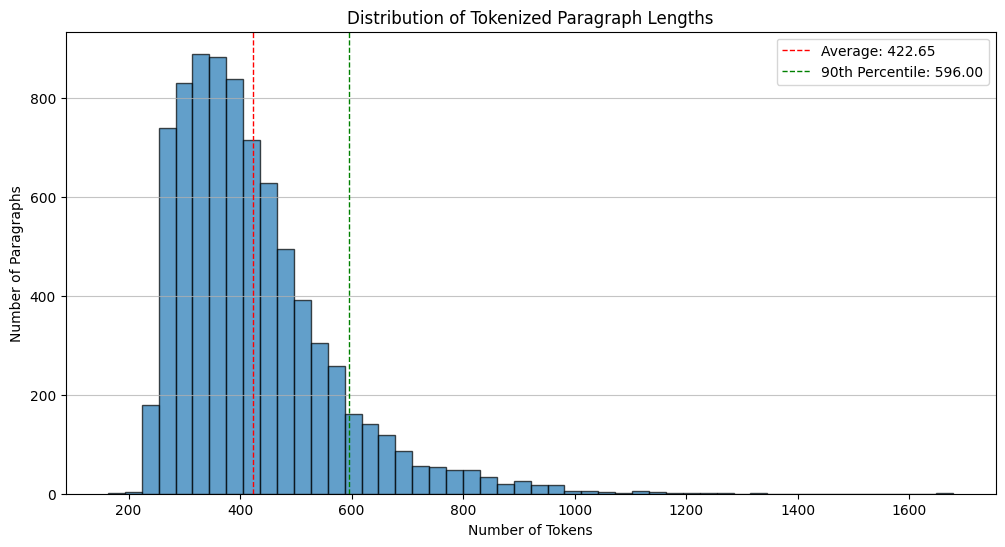

In [ ]:
import matplotlib.pyplot as plt
paragraph_lengths = [len(x) for x in train_paragraphs_tokenized['input_ids']]

average_length = np.mean(paragraph_lengths)
median_length = np.median(paragraph_lengths)
max_length = np.max(paragraph_lengths)
min_length = np.min(paragraph_lengths)
percentile_90 = np.percentile(paragraph_lengths, 90)


print(f"Tokenized Paragraph Length Statistics:")
print(f"  Min Length: {min_length}")
print(f"  Max Length: {max_length}")
print(f"  Average Length: {average_length:.2f}")
print(f"  Median Length: {median_length:.2f}")
print(f"  90th Percentile Length: {percentile_90:.2f}")

plt.figure(figsize=(12, 6))
plt.hist(paragraph_lengths, bins=50, edgecolor='black', alpha=0.7)
plt.title('Distribution of Tokenized Paragraph Lengths')
plt.xlabel('Number of Tokens')
plt.ylabel('Number of Paragraphs')
plt.grid(axis='y', alpha=0.75)
plt.axvline(average_length, color='r', linestyle='dashed', linewidth=1, label=f'Average: {average_length:.2f}')
plt.axvline(percentile_90, color='g', linestyle='dashed', linewidth=1, label=f'90th Percentile: {percentile_90:.2f}')
plt.legend()
plt.show()

## Dataset and Dataloader

Window 的主要作用就是從長的 paragraph中切出一小段。
切出來的paragraph片段會和[CLS],[SEP],問題的token IDs 組合成模型的輸入 (input_ids)。

In [ ]:
class QA_Dataset(Dataset):
    def __init__(self, split, questions, tokenized_questions, tokenized_paragraphs):
        self.split = split
        self.questions = questions #原始問題列表
        self.tokenized_questions = tokenized_questions #tokenized了的問題
        self.tokenized_paragraphs = tokenized_paragraphs
        self.max_question_len = 40
        self.max_paragraph_len = 400

        ##### TODO: Change value of doc_stride #####
        self.doc_stride = 300 #保留些許上下文，這裡不同window的overlap留100減少運算

        # Input sequence length = [CLS] + question + [SEP] + paragraph + [SEP]
        self.max_seq_len = 1 + self.max_question_len + 1 + self.max_paragraph_len + 1

    def __len__(self):
        return len(self.questions)

    def __getitem__(self, idx):
        question = self.questions[idx]
        tokenized_question = self.tokenized_questions[idx]
        tokenized_paragraph = self.tokenized_paragraphs[question["paragraph_id"]]

        ##### TODO: Preprocessing #####
        # Hint: How to prevent model from learning something it should not learn

        if self.split == "train":
            # Convert answer's start/end positions in paragraph_text to start/end positions in tokenized_paragraph
            answer_start_token = tokenized_paragraph.char_to_token(question["answer_start"])
            answer_end_token = tokenized_paragraph.char_to_token(question["answer_end"])

            # A single window is obtained by slicing the portion of paragraph containing the answer
            #將含有答案的附近分成兩個window,1:....here is 2:answer...，合成包含完整answer的window
            mid = (answer_start_token + answer_end_token) // 2
            paragraph_start = max(0, min(mid - self.max_paragraph_len // 2, len(tokenized_paragraph) - self.max_paragraph_len))
            paragraph_end = paragraph_start + self.max_paragraph_len

            # Slice question/paragraph and add special tokens (101: CLS, 102: SEP) #組合question, 和存在答案的文章區間, 分隔by[SEP]
            input_ids_question = [101] + tokenized_question.ids[:self.max_question_len] + [102]
            input_ids_paragraph = tokenized_paragraph.ids[paragraph_start : paragraph_end] + [102]

            # Convert answer's start/end positions in tokenized_paragraph to start/end positions in the window
            answer_start_token += len(input_ids_question) - paragraph_start #調整答案位置(在組合後的input sequence的哪裡)
            answer_end_token += len(input_ids_question) - paragraph_start

            # Pad sequence and obtain inputs to model #給model的問題+段落長度必須相同於self.max_seq_len by填空白
            input_ids, token_type_ids, attention_mask = self.padding(input_ids_question, input_ids_paragraph)
            #input_ids回傳加上特殊符號和空白的問題+段落ids的tensor，token_type_ids回傳和input_ids相同長但問題、padding為0，paragraph為1的tensor，attention_mask回傳相同長度且除了paragraph為1其他為0的tensor
            return torch.tensor(input_ids), torch.tensor(token_type_ids), torch.tensor(attention_mask), answer_start_token, answer_end_token

        # Validation/Testing
        else:
            input_ids_list, token_type_ids_list, attention_mask_list = [], [], []

            # Paragraph is split into several windows, each with start positions separated by step "doc_stride"
            for i in range(0, len(tokenized_paragraph), self.doc_stride):

                # Slice question/paragraph and add special tokens (101: CLS, 102: SEP)
                input_ids_question = [101] + tokenized_question.ids[:self.max_question_len] + [102]
                input_ids_paragraph = tokenized_paragraph.ids[i : i + self.max_paragraph_len] + [102]

                # Pad sequence and obtain inputs to model
                input_ids, token_type_ids, attention_mask = self.padding(input_ids_question, input_ids_paragraph)

                input_ids_list.append(input_ids)
                token_type_ids_list.append(token_type_ids)
                attention_mask_list.append(attention_mask)

            return torch.tensor(input_ids_list), torch.tensor(token_type_ids_list), torch.tensor(attention_mask_list)

    def padding(self, input_ids_question, input_ids_paragraph):
        # Pad zeros if sequence length is shorter than max_seq_len
        padding_len = self.max_seq_len - len(input_ids_question) - len(input_ids_paragraph)
        # Indices of input sequence tokens in the vocabulary
        input_ids = input_ids_question + input_ids_paragraph + [0] * padding_len
        # Segment token indices to indicate first and second portions of the inputs. Indices are selected in [0, 1]
        token_type_ids = [0] * len(input_ids_question) + [1] * len(input_ids_paragraph) + [0] * padding_len
        # Mask to avoid performing attention on padding token indices. Mask values selected in [0, 1]
        attention_mask = [1] * (len(input_ids_question) + len(input_ids_paragraph)) + [0] * padding_len

        return input_ids, token_type_ids, attention_mask

train_set = QA_Dataset("train", train_questions, train_questions_tokenized, train_paragraphs_tokenized)
dev_set = QA_Dataset("dev", dev_questions, dev_questions_tokenized, dev_paragraphs_tokenized)
test_set = QA_Dataset("test", test_questions, test_questions_tokenized, test_paragraphs_tokenized)

train_batch_size = 8

# Note: Do NOT change batch size of dev_loader / test_loader !
# Although batch size=1, it is actually a batch consisting of several windows from the same QA pair
train_loader = DataLoader(train_set, batch_size=train_batch_size, shuffle=True, pin_memory=True)
dev_loader = DataLoader(dev_set, batch_size=1, shuffle=False, pin_memory=True)
test_loader = DataLoader(test_set, batch_size=1, shuffle=False, pin_memory=True)

## Function for Evaluation

In [ ]:
def evaluate(data, output):
    ##### TODO: Postprocessing #####
    # There is a bug and room for improvement in postprocessing
    # Hint: Open your prediction file to see what is wrong

    answer = ''
    max_prob = float('-inf')
    num_of_windows = data[0].shape[1]

    for k in range(num_of_windows):
        # Obtain answer by choosing the most probable start position / end position
        start_prob, start_index = torch.max(output.start_logits[k], dim=0)
        end_prob, end_index = torch.max(output.end_logits[k], dim=0)

        # Probability of answer is calculated as sum of start_prob and end_prob
        prob = start_prob + end_prob

        # Replace answer if calculated probability is larger than previous windows
        if prob > max_prob:
            max_prob = prob
            # Convert tokens to chars (e.g. [1920, 7032] --> "大 金")
            answer = tokenizer.decode(data[0][0][k][start_index : end_index + 1])

    # Remove spaces in answer (e.g. "大 金" --> "大金")
    return answer.replace(' ','')

## Training

In [ ]:
num_epoch = 1
validation = True
logging_step = 100
learning_rate = 1e-4
optimizer = AdamW(model.parameters(), lr=learning_rate)

if fp16_training:
    model, optimizer, train_loader = accelerator.prepare(model, optimizer, train_loader)

#調learning rate
total_steps = len(train_loader) * num_epoch
print('total_steps', total_steps)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)


model.train()

print("Start Training ...")

for epoch in range(num_epoch):
  step = 1
  train_loss = train_acc = 0

  for data in tqdm(train_loader):
        # Load all data into GPU
    data = [i.to(device) for i in data]

        # Model inputs: input_ids, token_type_ids, attention_mask, start_positions, end_positions (Note: only "input_ids" is mandatory)
        # Model outputs: start_logits, end_logits, loss (return when start_positions/end_positions are provided)
    output = model(input_ids=data[0], token_type_ids=data[1], attention_mask=data[2], start_positions=data[3], end_positions=data[4])

        # Choose the most probable start position / end position
    start_index = torch.argmax(output.start_logits, dim=1)
    end_index = torch.argmax(output.end_logits, dim=1)

        # Prediction is correct only if both start_index and end_index are correct
    train_acc += ((start_index == data[3]) & (end_index == data[4])).float().mean()
    train_loss += output.loss

    if fp16_training:
        accelerator.backward(output.loss)
    else:
        output.loss.backward()

    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()
    step += 1

        ##### TODO: Apply linear learning rate decay #####

        # Print training loss and accuracy over past logging step
    if step % logging_step == 0:
        print(f"Epoch {epoch + 1} | Step {step} | loss = {train_loss.item() / logging_step:.3f}, acc = {train_acc / logging_step:.3f}")
        train_loss = train_acc = 0


total_steps 3367
Start Training ...


  0%|          | 0/3367 [00:00<?, ?it/s]

Epoch 1 | Step 100 | loss = 0.824, acc = 0.642
Epoch 1 | Step 200 | loss = 0.897, acc = 0.649
Epoch 1 | Step 300 | loss = 0.881, acc = 0.660
Epoch 1 | Step 400 | loss = 0.908, acc = 0.656
Epoch 1 | Step 500 | loss = 0.889, acc = 0.642
Epoch 1 | Step 600 | loss = 0.822, acc = 0.650
Epoch 1 | Step 700 | loss = 0.778, acc = 0.678
Epoch 1 | Step 800 | loss = 0.786, acc = 0.667
Epoch 1 | Step 900 | loss = 0.867, acc = 0.662
Epoch 1 | Step 1000 | loss = 0.716, acc = 0.684
Epoch 1 | Step 1100 | loss = 0.819, acc = 0.690
Epoch 1 | Step 1200 | loss = 0.770, acc = 0.667
Epoch 1 | Step 1300 | loss = 0.741, acc = 0.697
Epoch 1 | Step 1400 | loss = 0.691, acc = 0.691
Epoch 1 | Step 1500 | loss = 0.645, acc = 0.722
Epoch 1 | Step 1600 | loss = 0.759, acc = 0.714
Epoch 1 | Step 1700 | loss = 0.676, acc = 0.726
Epoch 1 | Step 1800 | loss = 0.688, acc = 0.714
Epoch 1 | Step 1900 | loss = 0.623, acc = 0.745
Epoch 1 | Step 2000 | loss = 0.598, acc = 0.727
Epoch 1 | Step 2100 | loss = 0.647, acc = 0.748
E

In [ ]:
if validation:
    print("Evaluating Dev Set ...")
    model.eval()
    with torch.no_grad():
        dev_acc = 0
        total_evaluated = 0
        for i, data in enumerate(tqdm(dev_loader)):
            output = model(input_ids=data[0].squeeze(dim=0).to(device), token_type_ids=data[1].squeeze(dim=0).to(device),
                           attention_mask=data[2].squeeze(dim=0).to(device))
            dev_acc += evaluate(data, output) == dev_questions[i]["answer_text"]
            total_evaluated += 1
        print(f"Validation | Epoch {epoch + 1} | acc = {dev_acc / total_evaluated:.3f}")
    model.train()

# Save a model and its configuration file to the directory 「saved_model」
# i.e. there are two files under the direcory 「saved_model」: 「pytorch_model.bin」 and 「config.json」
# Saved model can be re-loaded using 「model = BertForQuestionAnswering.from_pretrained("saved_model")」
print("Saving Model ...")
model_save_dir = "saved_model"
model.save_pretrained(model_save_dir)

Evaluating Dev Set ...


  0%|          | 0/3524 [00:00<?, ?it/s]

Validation | Epoch 1 | acc = 0.760
Saving Model ...


## Testing

In [ ]:
print("Evaluating Test Set ...")

result = []

model.eval()
with torch.no_grad():
    for data in tqdm(test_loader):
        output = model(input_ids=data[0].squeeze(dim=0).to(device), token_type_ids=data[1].squeeze(dim=0).to(device),
                       attention_mask=data[2].squeeze(dim=0).to(device))
        result.append(evaluate(data, output))

result_file = "result.csv"
with open(result_file, 'w') as f:
	f.write("ID,Answer\n")
	for i, test_question in enumerate(test_questions):
      # Replace commas in answers with empty strings (since csv is separated by comma)
      # Answers in kaggle are processed in the same way
		  f.write(f"{test_question['id']},{result[i].replace(',','')}\n")

print(f"Completed! Result is in {result_file}")

Evaluating Test Set ...


  0%|          | 0/3493 [00:00<?, ?it/s]

Completed! Result is in result.csv


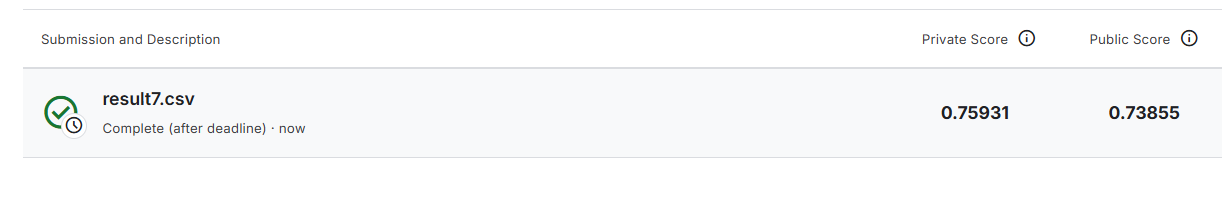